<b>Non-Maximum Suppression Performance Evaluation</b>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

from IPython.display import display

from tqdm import tqdm_notebook

import math
import h5py

from random import randrange

from matplotlib import patches
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable

from sklearn import metrics
from sklearn.model_selection import ParameterGrid

from utils import *

%load_ext watermark
%watermark -a "tb" -d -v -m -p sys,numpy,pandas,sklearn,torch,IPython
gpu_stat()

tb 2018-09-26 

CPython 3.6.4
IPython 6.2.1

sys 3.6.4 |Anaconda custom (64-bit)| (default, Jan 16 2018, 12:04:33) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
numpy 1.14.2
pandas 0.22.0
sklearn 0.19.2
torch 0.4.0a0+9692519
IPython 6.2.1

compiler   : GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 17.5.0
machine    : x86_64
processor  : i386
CPU cores  : 24
interpreter: 64bit

GPU Name: TITAN Xp
GPU Memory: 12.0GB
CUDA Version: (9, 1, 0)
GPU Free/Total Memory: 57%


In [2]:
#torch.cuda.is_available = lambda : False
#torch.backends.cudnn.enabled=False
torch.backends.cudnn.deterministic = True

In [3]:
seed = 0
np.random.seed(0)
torch.manual_seed(seed);
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

In [4]:
class LeNet_5_3(nn.Module):
    def __init__(self, D_in=(1,28,28), H=256, D_out=10, dropout=0.5, initialize=None, preload=None):
        super(LeNet_5_3, self).__init__()
        self.D_in = D_in
        self.H = H
        self.D_out = D_out
        self.droput = dropout
        self.initialize = initialize
        self.preload = preload

        self.conv1 = nn.Sequential(
            nn.Conv2d(D_in[0], 32, (3,3), stride=1, padding=2, bias=False),
            nn.BatchNorm2d(32, affine=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(32,  32, (3,3), stride=1, padding=0, bias=False),
            nn.BatchNorm2d(32, affine=True),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )
            
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, (3, 3), stride=1, padding=0, bias=False),
            nn.BatchNorm2d(64, affine=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, (3, 3), stride=1, padding=0, bias=False),
            nn.BatchNorm2d(64, affine=True),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )
        
        self.fc1 = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(64*5*5, H, bias=False),
            nn.BatchNorm1d(H, affine=True),
            nn.ReLU(inplace=True)
        )
        
        self.fc2 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        if not self.initialize is None:
            self.initialize(self)

        if self.preload is not None:
            self.load_state_dict(torch.load(self.preload))

    def forward(self, x):
        x = x.view(-1, self.D_in[0], self.D_in[1], self.D_in[2])
        
        x = self.conv1(x)
        x = self.conv2(x)

        x = x.view(-1, 64 * 5 * 5)
        
        x = self.fc1(x)
        x = self.fc2(x)
        
        return x

In [5]:
# Instanciate model and initialize with pre-trained parameters
model = LeNet_5_3(D_in=(1,28,28), D_out=10, H=128, initialize=None)
_ = model.load_state_dict(torch.load('./LeNet_5_3_model.tar'))

In [6]:
import numpy as np
import tensorlayer as tl
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import RandomOverSampler

X_train, y_train, X_valid, y_valid, X_test, y_test = tl.files.load_mnist_dataset(shape=(-1, 784))
target_names = ['0','1','2','3','4','5','6','7','8','9']

scaler = MinMaxScaler()
scaler.fit(X_train)

X_train, X_valid, X_test = scaler.transform(X_train), scaler.transform(X_valid), scaler.transform(X_test)

sampler = RandomOverSampler()
X_train, y_train = sampler.fit_sample(X_train, y_train)

idx = np.arange(X_train.shape[0])
np.random.shuffle(idx)
X_train, y_train = X_train[idx], y_train[idx]

dataset_statistics(X_train, y_train, X_valid, y_valid, X_test, y_test, target_names)

[TL] Load or Download MNIST > data/mnist
[TL] data/mnist/train-images-idx3-ubyte.gz
[TL] data/mnist/t10k-images-idx3-ubyte.gz



Dataset statistics:
number of features:            784
number of classes:             10
data type:                     float32
number of train samples:       56780 (size=178MB)
number of validation samples:  10000 (size=31MB)
number of test samples:        10000 (size=31MB)
classes                        ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
class percentages:
     1:    5678  =   10.0%
     0:    5678  =   10.0%
     2:    5678  =   10.0%
     9:    5678  =   10.0%
     6:    5678  =   10.0%
     7:    5678  =   10.0%
     3:    5678  =   10.0%
     8:    5678  =   10.0%
     4:    5678  =   10.0%
     5:    5678  =   10.0%


In [7]:
# simple wrapper around the pytorch model for MNIST digit classification
class Classifier(object):
    def __init__(self, model):
        self.model = model.cuda()
    @staticmethod
    def batch(iterable, n=1):
        l = len(iterable)
        for ndx in range(0, l, n):
            yield iterable[ndx:min(ndx + n, l)]
    @staticmethod            
    def to_np(x):
        return x.data.cpu().numpy()
    @staticmethod
    def to_var(x, async=False):
        if torch.cuda.is_available():
            x = x.cuda(async=async)
        return Variable(x)
    def predict(self, X):
            y_pred = []
            self.model.eval()
            with torch.no_grad():
                for X_batch in self.batch(X , 100):
                    inputs = torch.from_numpy(X_batch).float()
                    inputs = self.to_var(inputs)
                    outputs = self.model(inputs)
                    out = torch.max(outputs, 1)[1]
                    y_pred.extend( self.to_np( out ))

            return np.array(y_pred)     
    def predict_proba(self, X):
        y_pred = []
        self.model.eval()
        with torch.no_grad():
            for X_batch in self.batch(X , 100):
                inputs = torch.from_numpy(X_batch).float()
                inputs = self.to_var(inputs)
                outputs = self.model(inputs)
                y_pred.extend( self.to_np( outputs ))
        return np.array(y_pred)

In [8]:
clf = Classifier(model)

In [9]:
y_pred = clf.predict(X_test)
print('Confusion Matrix\n', metrics.confusion_matrix(y_test, y_pred))
print('Accuracy     ', metrics.accuracy_score(y_test, y_pred) * 100)
print('Recall       ', metrics.recall_score(y_test, y_pred, average='macro') * 100)
print('Precision    ', metrics.precision_score(y_test, y_pred, average='macro') * 100)
print('F1           ', metrics.f1_score(y_test, y_pred, average='macro') * 100)
print('Error rate(%)', (np.sum(y_test != y_pred)/y_test.shape[0]) * 100)

Confusion Matrix
 [[ 979    0    0    0    0    0    0    1    0    0]
 [   0 1133    0    0    0    0    1    1    0    0]
 [   1    0 1028    0    0    0    1    2    0    0]
 [   0    0    0 1008    0    2    0    0    0    0]
 [   0    1    0    0  976    0    0    0    1    4]
 [   0    0    0    2    0  889    1    0    0    0]
 [   3    3    0    0    0    0  950    0    2    0]
 [   0    2    2    0    0    0    0 1024    0    0]
 [   1    0    0    1    0    1    0    0  970    1]
 [   0    0    0    0    4    0    0    1    0 1004]]
Accuracy      99.61
Recall        99.60584143113485
Precision     99.61251263061
F1            99.60900963922936
Error rate(%) 0.38999999999999996


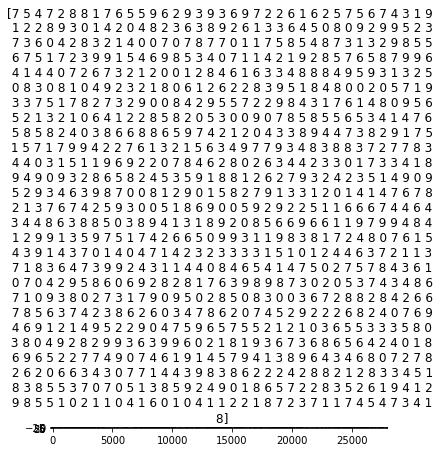

In [10]:
%matplotlib inline

sequence_len = 1000
data_len = X_test.shape[0]
idx = np.random.permutation(data_len)
X_sequences = [np.concatenate(x, axis=1) for x in np.split(X_test[idx].reshape(-1, 28,28), data_len / sequence_len)]
y_sequences = [y for y in np.split(y_test[idx], data_len / sequence_len)]

plt.title(str(y_sequences[0]))
plt.imshow(X_sequences[0], cmap='gray')
plt.show()

In [11]:
# Numpy implemementation of NMS
# https://gitlab.informatik.haw-hamburg.de/acf530/ssd-pytorch/blob/bc72ac7d50bf8905e6f8f5650254365e931b97d4/box_matcher.py

class BoxDetector_numpy:
    def __init__(self, clf, box_size, step_size, threshold, mode='union'):
        self.clf = clf
        self.box_size = box_size
        self.step_size = step_size
        self.threshold = threshold
        self.mode = mode
    
    def sliding_window(self, image):
        for y in range(0, image.shape[0], self.step_size[1]):
            for x in range(0, image.shape[1], self.step_size[0]):
                yield (x, y, image[y:y + self.box_size[1], x:x + self.box_size[0]])
                
    def predict_proba(self, clf, image):
        y_proba = clf.predict_proba(np.array([image])).flatten()

        idx = np.flip(np.argsort(y_proba), 0)
        res = [(i,p) for i,p in zip(idx, y_proba[idx])][0:5]
        return res

    def convert_to_two_point_form(self, boxes):
        """
        Convert boxes in form (cx,cy,w,h) to (x1,y1,x2,y2)
        :param boxes: tensor of n boxes in form (cx,cy,w,h)
        :return: tensor of n boxes in form (x1,y1,x2,y2)
        """
        return np.concatenate(([boxes[:, :2], boxes[:, :2] + boxes[:, 2:]]), 1)    
        
    def nms(self, dets, thresh):
        x1, y1 = dets[:, 0], dets[:, 1]
        x2, y2 = dets[:, 2], dets[:, 3]
        scores = dets[:, 4]

        areas = (x2 - x1 + 1) * (y2 - y1 + 1)
        order = scores.argsort()[::-1]

        keep = []
        while order.size > 0:
            i = order[0]
            keep.append(i)
            
            xx1 = np.maximum(x1[i], x1[order[1:]])
            yy1 = np.maximum(y1[i], y1[order[1:]])
            xx2 = np.minimum(x2[i], x2[order[1:]])
            yy2 = np.minimum(y2[i], y2[order[1:]])

            w = np.maximum(0.0, xx2 - xx1 + 1)
            h = np.maximum(0.0, yy2 - yy1 + 1)
            intersections = w * h
            overlaps = intersections / (areas[i] + areas[order[1:]] - intersections)

            inds = np.where(overlaps <= thresh)[0]
            order = order[inds + 1]

        return np.array(keep)
    
    def box_proposals(self, image):
        boxes = []
        scores = []
        for (x, y, box) in self.sliding_window(image):
            if box.shape[0] != self.box_size[1] or box.shape[1] != self.box_size[0]:
                continue

            score = self.predict_proba(clf, box)
            
            boxes.append((x, y, box.shape[0], box.shape[1]))
            scores.append((score[0][1], score[0][0]))
    
        boxes = self.convert_to_two_point_form(np.array(boxes))

        scores = np.array(scores)
        
        dets = np.concatenate((boxes, scores[:,0:1]), 1)
        
        idx = self.nms(dets, self.threshold)
        boxes, scores = boxes[idx], scores[idx]

        idx = boxes[:,0:1].argsort(axis=0).flatten()
        
        return boxes[idx], scores[idx]


In [12]:
img = X_sequences[0]
labels = y_sequences[0]

detector = BoxDetector_numpy(clf, box_size = (28, 28), step_size = (1, 1), threshold=0.2, mode='union')
%time boxes, scores = detector.box_proposals(img)
print(len(boxes))

CPU times: user 33.4 s, sys: 92.7 ms, total: 33.5 s
Wall time: 33.4 s
1002


In [13]:
# GPU implementation of NMS
# nms implementation from https://github.com/jwyang/faster-rcnn.pytorch
# compile the lib folder as described in the readme
# creat a link in the home directory (./) to the model directory in faster-rcnn.pytorch (or simply copy it)
# install pip install easydict if requested by an error message

from model.nms.nms_wrapper import nms_gpu

class BoxDetector_gpu:
    def __init__(self, clf, box_size, step_size, threshold):
        self.clf = clf
        self.box_size = box_size
        self.step_size = step_size
        self.threshold = threshold
    
    def sliding_window(self, image):
        for y in range(0, image.shape[0], self.step_size[1]):
            for x in range(0, image.shape[1], self.step_size[0]):
                yield (x, y, image[y:y + self.box_size[1], x:x + self.box_size[0]])
                
    def predict_proba(self, clf, image):
        y_proba = clf.predict_proba(np.array([image])).flatten()

        idx = np.flip(np.argsort(y_proba), 0)
        res = [(i,p) for i,p in zip(idx, y_proba[idx])][0:5]
        return res

    def convert_to_two_point_form(self, boxes):
        """
        Convert boxes in form (cx,cy,w,h) to (x1,y1,x2,y2)
        :param boxes: tensor of n boxes in form (cx,cy,w,h)
        :return: tensor of n boxes in form (x1,y1,x2,y2)
        """
        return torch.cat([boxes[:, :2], boxes[:, :2] + boxes[:, 2:]], 1)    
        
    def box_proposals(self, image):
        boxes = []
        scores = []
        for (x, y, box) in self.sliding_window(image):
            if box.shape[0] != self.box_size[1] or box.shape[1] != self.box_size[0]:
                continue

            score = self.predict_proba(clf, box)
            
            boxes.append((x, y, box.shape[0], box.shape[1]))
            scores.append((score[0][1], score[0][0]))
    

        boxes = torch.from_numpy(np.array(boxes)).float()
        boxes = self.convert_to_two_point_form(boxes)

        scores = torch.from_numpy(np.array(scores)).float()
        _, order = scores[:,0].sort(0, descending=True)
        boxes, scores = boxes[order], scores[order]
        
        cls_dets = torch.cat((boxes, scores[:,0].unsqueeze(1)), 1)

        idx = nms_gpu(cls_dets.cuda(), self.threshold).squeeze().long().cpu()
        boxes, scores = boxes[idx], scores[idx]
        
        _, idx = boxes[:,0].sort(0, descending=False)
                
        return boxes[idx].cpu().int(), scores[idx].cpu()

In [14]:
img = X_sequences[0]
labels = y_sequences[0]

detector = BoxDetector_gpu(clf, box_size = (28, 28), step_size = (1, 1), threshold=0.2)
%time boxes, scores = detector.box_proposals(img)
print(len(boxes))

CPU times: user 32.9 s, sys: 116 ms, total: 33 s
Wall time: 33 s
1002


In [15]:
# Pytorch implementation of NMS
class BoxDetector_torch:
    def __init__(self, clf, box_size, step_size, threshold, mode='union'):
        self.clf = clf
        self.box_size = box_size
        self.step_size = step_size
        self.threshold = threshold
        self.mode = mode
    
    def sliding_window(self, image):
        for y in range(0, image.shape[0], self.step_size[1]):
            for x in range(0, image.shape[1], self.step_size[0]):
                yield (x, y, image[y:y + self.box_size[1], x:x + self.box_size[0]])
                
    def predict_proba(self, clf, image):
        y_proba = clf.predict_proba(np.array([image])).flatten()

        idx = np.flip(np.argsort(y_proba), 0)
        res = [(i,p) for i,p in zip(idx, y_proba[idx])][0:5]
        return res

    def convert_to_two_point_form(self, boxes):
        """
        Convert boxes in form (cx,cy,w,h) to (x1,y1,x2,y2)
        :param boxes: tensor of n boxes in form (cx,cy,w,h)
        :return: tensor of n boxes in form (x1,y1,x2,y2)
        """
        return torch.cat([boxes[:, :2], boxes[:, :2] + boxes[:, 2:]], 1)    
    
    def nms(self, bboxes, scores, threshold=0.3, mode='union'):
        '''Non maximum suppression.
        Args:
          bboxes: (tensor) bounding boxes, sized [N,4].
          scores: (tensor) bbox scores, sized [N,].
          threshold: (float) overlap threshold.
          mode: (str) 'union' or 'min'.
        Returns:
          keep: (tensor) selected indices.
        Ref:
          https://github.com/rbgirshick/py-faster-rcnn/blob/master/lib/nms/py_cpu_nms.py
        '''
        x1 = bboxes[:, 0]
        y1 = bboxes[:, 1]
        x2 = bboxes[:, 2]
        y2 = bboxes[:, 3]

        areas = ((x2 - x1) * (y2 - y1)).float()
        _, order = scores.sort(0, descending=True)
                
        keep = []
        while order.numel() > 0:
            i = order[0]
            keep.append(i)

            if order.numel() == 1:
                break

            xx1 = x1[order[1:]].clamp(min=x1[i])
            yy1 = y1[order[1:]].clamp(min=y1[i])
            xx2 = x2[order[1:]].clamp(max=x2[i])
            yy2 = y2[order[1:]].clamp(max=y2[i])

            w = (xx2 - xx1).clamp(min=0)
            h = (yy2 - yy1).clamp(min=0)
            inter = (w * h).float()
            
            if mode == 'union':
                ovr = inter / (areas[i] + areas[order[1:]] - inter)
            elif mode == 'min':
                ovr = inter / areas[order[1:]].clamp(max=areas[i])
            else:
                raise TypeError('Unknown nms mode: %s.' % mode)

            ids = (ovr <= threshold).nonzero().squeeze()
            if ids.numel() == 0:
                break
            
            order = order[ids + 1]
        return torch.LongTensor(keep)
    
    def box_proposals(self, image):
        boxes = []
        scores = []
        for (x, y, box) in self.sliding_window(image):
            if box.shape[0] != self.box_size[1] or box.shape[1] != self.box_size[0]:
                continue

            score = self.predict_proba(clf, box)
            
            boxes.append((x, y, box.shape[0], box.shape[1]))
            scores.append((score[0][1], score[0][0]))
    

        boxes = torch.from_numpy(np.array(boxes))
        boxes = self.convert_to_two_point_form(boxes)

        scores = torch.from_numpy(np.array(scores))

        idx = self.nms(boxes, scores[:,0], self.threshold, self.mode)
        #idx = self.nms(boxes.cuda(), scores[:,0].cuda(), self.threshold, self.mode).cpu()
        
        boxes, scores = boxes[idx], scores[idx]
    
        _, idx = boxes[:,0].sort(0, descending=False)
                
        return boxes[idx], scores[idx]


In [16]:
img = X_sequences[0]
labels = y_sequences[0]

detector = BoxDetector_torch(clf, box_size = (28, 28), step_size = (1, 1), threshold=0.2)
%time boxes, scores = detector.box_proposals(img)
print(len(boxes))

CPU times: user 33 s, sys: 111 ms, total: 33.1 s
Wall time: 33.1 s
1002


In [17]:
# Python List implementation of NMS
class BoxDetector_list:
    def __init__(self, clf, box_size, step_size, threshold):
        self.clf = clf
        self.box_size = box_size
        self.step_size = step_size
        self.threshold = threshold
    
    def sliding_window(self, image):
        for y in range(0, image.shape[0], self.step_size[1]):
            for x in range(0, image.shape[1], self.step_size[0]):
                yield (x, y, image[y:y + self.box_size[1], x:x + self.box_size[0]])
                
    def predict_proba(self, clf, image):
        y_proba = clf.predict_proba(np.array([image])).flatten()

        idx = np.flip(np.argsort(y_proba), 0)
        res = [(i,p) for i,p in zip(idx, y_proba[idx])][0:5]
        return res

    def iou(self, box1, box2):
        x1, x2 = box1[0], box2[0]
        y1, y2 = box1[1], box2[1]

        x3, x4 = box1[0] + box1[2], box2[0] + box2[2]
        y3, y4 = box1[1] + box1[3], box2[1] + box2[3]

        x_overlap = max(0, min(x3, x4) - max(x1, x2))
        y_overlap = max(0, min(y3, y4) - max(y1, y2))
        intersection = x_overlap * y_overlap

        area_1 = box1[2] * box2[3]
        area_2 = box2[2] * box2[3]
        area = area_1 + area_2 - intersection

        return intersection / float(area)
    
    def nms(self, boxes):
        """
        Greedy Non-maximum suppression implemented as an iterative process. Finds the box
        with the maximum score and rejects all boxes that have an IoU (Intersection of union) 
        larger than a threshold.
        """
        if len(boxes) == 0:
            return []

        boxes = sorted(boxes, key=lambda box: box[4][0][1], reverse=False)
        
        retained_boxes=[]
        retained_boxes.append(boxes.pop())

        while len(boxes) > 0:
            box = boxes.pop()
            for new_box in retained_boxes:
                if self.iou(box, new_box) > self.threshold:
                    break
            else:
                retained_boxes.append(box)
                
        return retained_boxes
    
    def box_proposals(self, image):
        boxes = []
        for (x, y, box) in self.sliding_window(image):
            if box.shape[0] != self.box_size[1] or box.shape[1] != self.box_size[0]:
                continue

            # box classifier
            score = self.predict_proba(clf, box)
            
            # yields a box described by a tuple {x,y,w,h,s} of a possible detection
            boxes.append((x, y, box.shape[0], box.shape[1], score))

        retained_boxes = self.nms(boxes)
        
        retained_boxes = sorted(retained_boxes, key=lambda box: box[0], reverse=False)
        
        return retained_boxes

In [18]:
img = X_sequences[0]
labels = y_sequences[0]

detector = BoxDetector_list(clf, box_size = (28, 28), step_size = (1, 1), threshold=0.2)
%time boxes = detector.box_proposals(img)
print(len(boxes))

CPU times: user 1min 4s, sys: 147 ms, total: 1min 4s
Wall time: 1min 4s
1002
